# This notebook demonstrates how to adversarially attack a CIFAR10 model, extract representations, analyze with MFTMA, and plot the results.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from glob import glob

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from art.utils import load_cifar10

## Setup the MFTMA parameters

We provide example parameters for two types of analysis. 

1. Class manifold analysis, for the traditional class label manifolds (ie many examples from the same class compose a class manifold). 

2. Exemplar manifold analysis, which constructs a manifold around individual stimuli (ie each manifold is composed of a single exemplar with variability from stochastic representations and/or adversarial perturbations). 

Uncomment the section in the cell below for the type of analysis you want to run. 

In [3]:
seed = 0

## 1. class manifolds analysis example parameters 
manifold_type = 'class' # 'class' for traditional label based manifolds, 'exemplar' for individual exemplar manifolds
P = 10 # number of manifolds
M = 50 # number of examples per manifold
N = 2000 # maximum number of features to use

# determine the type of adversarial examples to use for constructing the manifolds
eps = 1/255 
max_iter = 16
eps_step_factor = 4
eps_step = eps / eps_step_factor
random = False # adversarial perturbation if false, random perturbation if true

## 2. exemplar manifolds analysis example parameters 
# manifold_type = 'exemplar' # 'class' for traditional label based manifolds, 'exemplar' for individual exemplar manifolds
# P = 50 # number of manifolds
# M = 50 # number of examples per manifold
# N = 2000 # maximum number of features to use

# determine the type of adversarial examples to use for constructing the manifolds
# eps = 8/255
# max_iter = 1
# eps_step_factor = 1
# eps_step = eps / eps_step_factor
# random = False # adversarial perturbation if false, random perturbation if true

## Choose the model that you want to analyze, and the dataset to use. 

We provide two CIFAR10 models for comparison.

`CIFAR_ResNet18`: Standard ResNet18 architecture trained on CIFAR

`CIFAR_VOneResNet18`: ResNet18 architecture with a Gaussian noise VOne block replacing the first conv-relu-maxpool. 

In [4]:
# model and dataset details

## regular VOneResNet18
model_name = 'CIFAR_ResNet18'

## VOneResNet18 with Gaussian noise
# model_name = 'CIFAR_VOneResNet18'

dataset = 'CIFAR'

# where to save results and how to name the files
results_dir = 'results'
file_name = f'model_{model_name}-manifold_{manifold_type}-eps_{eps}-iter_{max_iter}-random_{random}-seed_{seed}.csv'

## Load the model and dataset

In [5]:
from helpers import load_model, art_wrap_model, accuracy

In [6]:
# load the model
model = load_model(model_name, 'cpu')

# wrap the model with adversarial robustness toolbox, for generating adversarial stimuli.
classifier = art_wrap_model(model, device_type='cpu')

/om4/group/mcdermott/user/jfeather/conda_envs_files/adversarial_manifolds_python_37/lib/python3.7/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/om4/group/mcdermott/user/jfeather/conda_envs_files/adversarial_manifolds_python_37/lib/python3.7/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/om4/group/mcdermott/user/jfeather/conda_envs_files/adversarial_manifolds_python_37/lib/python3.7/site

((50000, 3, 32, 32), (10000, 3, 32, 32))

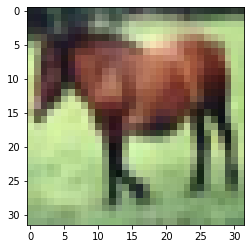

In [7]:
# Train and test dataset, and show an example. 
(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_cifar10()
plt.imshow(x_train[7])

x_train = x_train.transpose(0,3,1,2).astype(np.float32)
x_test = x_test.transpose(0,3,1,2).astype(np.float32)

x_train.shape, x_test.shape

In [8]:
# get model clean accuracy
predictions = classifier.predict(x_test)
clean_accuracy = accuracy(predictions, y_test)
print("Accuracy on benign test examples: {}%".format(clean_accuracy * 100))

Accuracy on benign test examples: 94.91000000000001%


## Generate adversarial manifold stimuli

Each manifold is constructed from the adversarially perturbed examples from $L_\infty$ perturbations. We also evaluate the accuracy on these perturbed stimuli.  

In [9]:
from helpers import perturb_stimuli, construct_manifold_stimuli

In [10]:
X, Y = construct_manifold_stimuli(x_test, y_test, manifold_type, P=P, M=M)
X_adv = perturb_stimuli(
    X, 
    Y, 
    classifier, 
    eps=eps, 
    eps_step_factor=eps_step_factor, 
    max_iter=max_iter, 
    random=random
)

print(f'stimuli shape: {X_adv.shape}')

# get adversarial accuracy
adv_accuracy = accuracy(classifier.predict(X_adv), Y)
print(f"Accuracy on adversarial test examples: {adv_accuracy * 100}")

/om4/group/mcdermott/user/jfeather/conda_envs_files/adversarial_manifolds_python_37/lib/python3.7/site-packages/art/estimators/classification/pytorch.py:694: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_grad = torch.tensor(x).to(self._device)
/om4/group/mcdermott/user/jfeather/conda_envs_files/adversarial_manifolds_python_37/lib/python3.7/site-packages/art/estimators/classification/pytorch.py:695: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_grad = torch.tensor(y).to(self._device)


stimuli shape: (500, 3, 32, 32)
Accuracy on adversarial test examples: 40.8


## Extract activations and run MFTMA 

The manifolds constructed from adversarial examples above are run through the MFTMA pipeline.

All of the MFTMA metrics are saved out along with metadata about the analysis. 

In [11]:
from helpers import Hook, model_layer_map, MFTMA_analyze_activations

In [12]:
# apply hooks to the model, to extract intermediate representations
hooks = {}

for layer_name, module in model_layer_map(model_name, model).items():
    hooks[layer_name] = Hook(module, layer_name)

In [13]:
# run the perturbed stimuli through the model
Y_hat = model(torch.tensor(X_adv))

# put activations and pixels into a dictionary with layer names
features_dict = {layer_name: hook.activations for layer_name, hook in hooks.items()}
features_dict['0.pixels'] = X_adv

In [14]:
# run MFTMA analysis on the features -- this can take a few minutes
df = MFTMA_analyze_activations(features_dict, P, M, N=N, seed=seed)

## add additional meta data
df['model'] = model_name
df['manifold_type'] = manifold_type
df['eps'] = eps
df['eps_step'] = eps_step
df['max_iter'] = max_iter
df['random'] = random

In [15]:
# store the results
df.to_csv(os.path.join(results_dir, file_name))

# TODO: some explanation about how the dataframe is formatted... what is each row? Does this run all of the layers? 

## Run multiple seeds and models
Here, all of the above is wrapped together into a single function, for easier use. 

We run the analysis 5 random projection seeds to use for error bars. We also run the analysis on both of the networks. 

Each MFTMA analysis can take a few minutes to run.  

In [18]:
from helpers import MFTMA_analyze_adversarial_representations

In [19]:
models = ['CIFAR_ResNet18', 'CIFAR_VOneResNet18']

args_sets = [
    dict(seeds=5,
         manifold_type=manifold_type,
         P=P,
         M=M,
         N=N,
         eps=eps,
         eps_step_factor=eps_step_factor,
         max_iter=max_iter,
         random=random,
         model_name=model,
         dataset=dataset,
         device='cpu')
    for model in models
]

for args in args_sets:
    MFTMA_analyze_adversarial_representations(args)

/om4/group/mcdermott/user/jfeather/conda_envs_files/adversarial_manifolds_python_37/lib/python3.7/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/om4/group/mcdermott/user/jfeather/conda_envs_files/adversarial_manifolds_python_37/lib/python3.7/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/om4/group/mcdermott/user/jfeather/conda_envs_files/adversarial_manifolds_python_37/lib/python3.7/site

Accuracy on benign test examples: 94.91000000000001%


/om4/group/mcdermott/user/jfeather/conda_envs_files/adversarial_manifolds_python_37/lib/python3.7/site-packages/art/estimators/classification/pytorch.py:694: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_grad = torch.tensor(x).to(self._device)
/om4/group/mcdermott/user/jfeather/conda_envs_files/adversarial_manifolds_python_37/lib/python3.7/site-packages/art/estimators/classification/pytorch.py:695: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_grad = torch.tensor(y).to(self._device)


stimuli shape: (500, 3, 32, 32)
Accuracy on adversarial test examples: 40.0


/om4/group/mcdermott/user/jfeather/conda_envs_files/adversarial_manifolds_python_37/lib/python3.7/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'vonenet.modules.VOneBlock' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/om4/group/mcdermott/user/jfeather/conda_envs_files/adversarial_manifolds_python_37/lib/python3.7/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/om4/group/mcdermott/user/jfeather/conda_envs_files/adversarial_manifolds_python_37/lib/python3.7/site-packages

Accuracy on benign test examples: 89.17%


/om4/group/mcdermott/user/jfeather/conda_envs_files/adversarial_manifolds_python_37/lib/python3.7/site-packages/art/estimators/classification/pytorch.py:694: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_grad = torch.tensor(x).to(self._device)
/om4/group/mcdermott/user/jfeather/conda_envs_files/adversarial_manifolds_python_37/lib/python3.7/site-packages/art/estimators/classification/pytorch.py:695: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_grad = torch.tensor(y).to(self._device)


stimuli shape: (500, 3, 32, 32)
Accuracy on adversarial test examples: 83.39999999999999


## Load past results and plot

We plot an analysis of the class and exemplar manifolds for each layer (saved data is used as an example).

In [20]:
from helpers import plot_layerwise

In [21]:
# load subsequent results with CIFAR dataset
files = [y for x in os.walk(results_dir) for y in glob(os.path.join(x[0], f'*{dataset}*'))]
df = pd.concat([pd.read_csv(f) for f in files])
df.head(3)

,Unnamed: 0,cap,dim,rad,mean_cap,center_corr,K,EVD90,PR,P,M,N,layer,seed,model,manifold_type,eps,eps_step,max_iter,random
0,0,0.074497,22.781711,1.177806,0.056824,0.410013,1,147,29.852506,10,50,2000,1.conv1,0,CIFAR_ResNet18,class,0.003922,0.00098,16,False
1,1,0.054485,28.811701,1.306477,0.056824,0.410013,1,147,29.852506,10,50,2000,1.conv1,0,CIFAR_ResNet18,class,0.003922,0.00098,16,False
2,2,0.047767,31.232530,1.459273,0.056824,0.410013,1,147,29.852506,10,50,2000,1.conv1,0,CIFAR_ResNet18,class,0.003922,0.00098,16,False


In [22]:
# define MFTMA and other measures to plot
measures = ['mean_cap', 'dim', 'rad', 'center_corr', 'EVD90', 'PR']

### Plot class manifold results layerwise

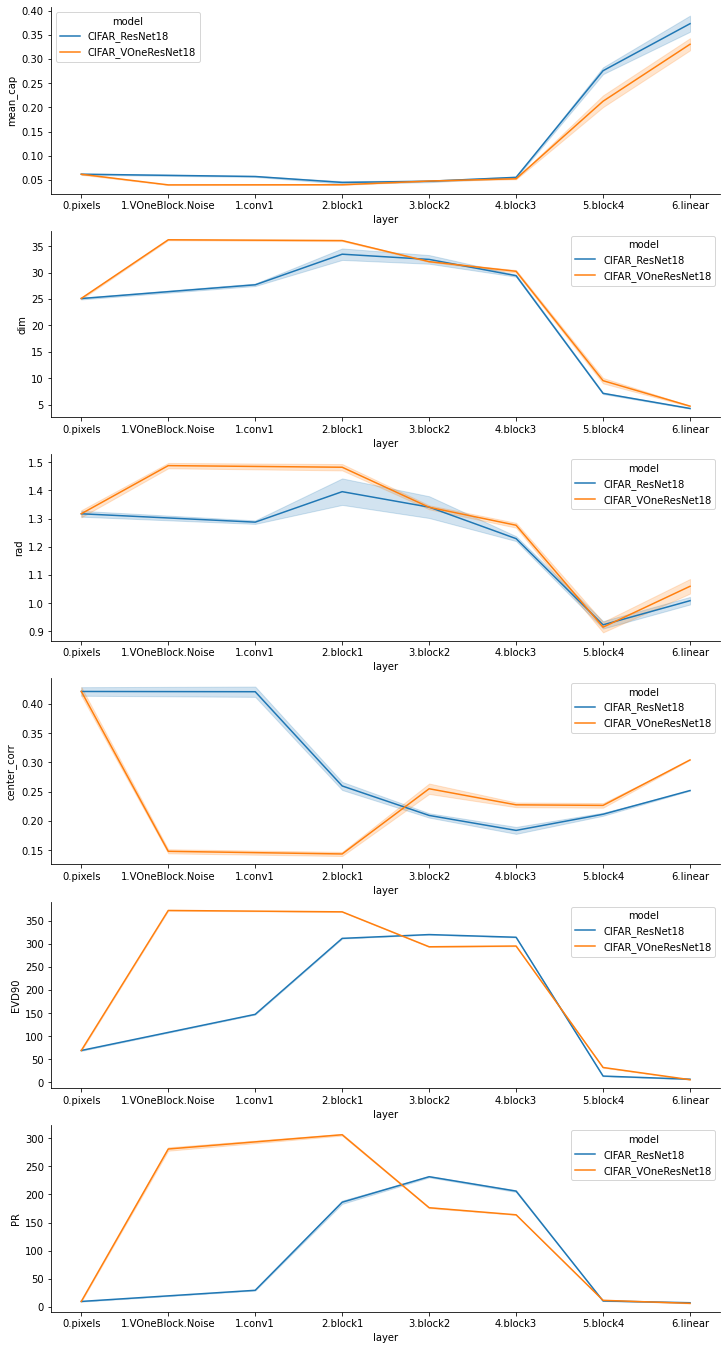

In [23]:
manifold_type = 'class' # 'class' for traditional label based manifolds, 'exemplar' for individual exemplar manifolds
eps = 1/255
plot_layerwise(df, measures, eps=eps, manifold_type=manifold_type)

### Plot exemplar manifold results layerwise

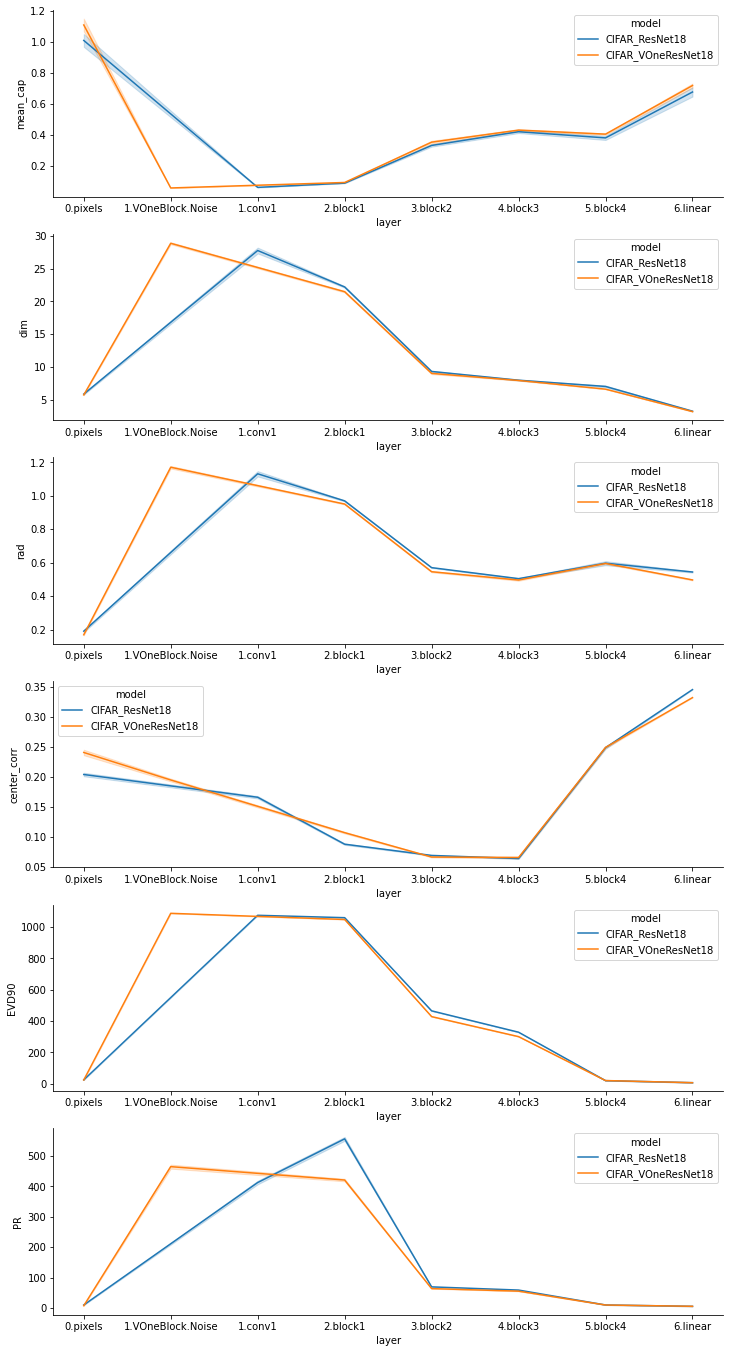

In [24]:
manifold_type = 'exemplar' # 'class' for traditional label based manifolds, 'exemplar' for individual exemplar manifolds
eps = 8/255
plot_layerwise(df, measures, eps=eps, manifold_type=manifold_type)